<a>
    <img src="https://ladata-ufs.github.io/Assets/LOGO-EXTENSO-CLARA.png" width=175>
</a>

# **Processamento de Linguagem Natural: das abordagens clássicas aos LLMs**  
> Túlio Gois; Ana Laylla Rocha; Daivik Celeste; David Henrique Ferraz; Letícia Santos.

---
## **Dia 2: Das abordagens clássicas aos LLMs**

### **Dependências**

In [55]:
#instalações
!pip install --quiet transformers torch scikit-learn huggingface_hub safetensors matplotlib scipy

In [56]:
#imports
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import spacy
import torch
from collections import defaultdict
from huggingface_hub import hf_hub_download
from safetensors.numpy import load_file
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel, pipeline
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## **Atribuindo significado**
Chegamos na semântica, a área que estuda o significado de frases e palavras.  
Em PLN, trabalhamos principalmente com uma coisa chamada **semântica distribucional**. Essa é uma abordagem baseada na **Hipótese Distribucional**, que dita que palavras que aparecem em um contexto linguístico semelhante tendem a ter um significado similar ou aproximado.

Adentrando um pouco mais a parte computacional, nessa abordagem, **as palavras são representadas por meio de vetores numéricos**, conhecidos como **vetores semânticos**, que codificam os seus significados a partir da sua distribuição em textos.

Por se basearem em distribuição, esses vetores podem ser aprendidos de forma automática a partir de textos — aprendizado não-supervisionado. Os modelos que aprendem esse tipo de representação são chamados de **Modelos Semânticos Distribucionais - MSD**.

## **Semântica Vetorial**
A representação vetorial semântica, ou simplesmente vetores semânticos, é um padrão
de representação muito usual em PLN, que pode retratar vários aspectos do significado das
palavras, como a similaridade , a orientação de sentimento
ou polaridade, a associação entre palavras , entre outros.

Os vetores podem ser divididos principalmente em **esparsos** e **densos**.

* **Vetores esparsos**: o
significado de uma palavra é representado por meio de uma função simples calculada com
base na frequência da palavra em uma coleção de documentos;
* **Vetores densos**: o significado de uma palavra é dado através de números reais que representam propriedades semânticas úteis aprendidas em um conjunto de textos.

### **Matriz termo-documento**
Na matriz termo-documento, o espaço vetorial é formado por uma coleção de documentos (textos, parágrafos ou documentos completos) que representam pontos nesse espaço.

In [57]:
corpus = [
    "O estudante leu o livro na biblioteca.",
    "O banco enviou o cartão para o estudante.",
    "O livro ensina sobre processamento de linguagem."
]

In [58]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
vocabulario = vectorizer.get_feature_names_out()

df_td = pd.DataFrame(X.toarray(), index=[f"Doc {i+1}" for i in range(len(corpus))], columns=vocabulario)

print("Matriz Termo-Documento (Frequência Bruta):")
display(df_td.T)

Matriz Termo-Documento (Frequência Bruta):


,Doc 1,Doc 2,Doc 3
banco,0,1,0
biblioteca,1,0,0
cartão,0,1,0
de,0,0,1
ensina,0,0,1
enviou,0,1,0
estudante,1,1,0
leu,1,0,0
linguagem,0,0,1
livro,1,0,1


### **Matriz termo-contexto**
Essa é a matriz utilizada para representar o significado de palavras. Também conhecida como matriz palavra-palavra ou termo-termo, ela tem um espaço vetorial formado por uma coleção de palavras.

In [59]:
def gerar_matriz_coocorrencia(corpus, janela=1):
    vocab = set()
    coocorrencia = defaultdict(lambda: defaultdict(int))

    tokens_list = [nltk.word_tokenize(doc.lower()) for doc in corpus]
    for tokens in tokens_list:
        vocab.update(tokens)
        for i, token in enumerate(tokens):
            # Define o contexto (janela à esquerda e à direita)
            inicio = max(0, i - janela)
            fim = min(len(tokens), i + janela + 1)
            contexto = tokens[inicio:i] + tokens[i+1:fim]

            for ctx_word in contexto:
                coocorrencia[token][ctx_word] += 1

    vocab = sorted(list(vocab))
    df = pd.DataFrame(0, index=vocab, columns=vocab)

    for word1 in vocab:
        for word2 in vocab:
            df.loc[word1, word2] = coocorrencia[word1][word2]

    return df

print(f"Matriz Termo-Contexto (Coocorrência com janela=1):")
df_cooc = gerar_matriz_coocorrencia(corpus, janela=1)
display(df_cooc)

Matriz Termo-Contexto (Coocorrência com janela=1):


,.,banco,biblioteca,cartão,de,ensina,enviou,estudante,leu,linguagem,livro,na,o,para,processamento,sobre
.,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0
banco,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
biblioteca,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
cartão,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
de,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
ensina,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
enviou,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
estudante,1,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0
leu,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
linguagem,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### **Similaridade semântica**
A medida do Cosseno é uma das maneiras mais conhecidas de medir similaridade semântica entre dois vetores. Ela calcula a distância entre os dois vetores a partir do valor do cosseno do ângulo entre eles.
* É calculada através do produto escalar entre dois vetores
* A medida do cosseno, para a similaridade semântica, gira em torno do intervalo fechado [0, 1]
* Quanto mais próxima de 1, maior a similaridade
* É menos sensível à frequência de ocorrência das palavras no corpus


A fórmula utilizada é:
$$Cos(\theta) = \frac{A \cdot B}{||A|| \cdot ||B||}$$

In [60]:
df_tc = gerar_matriz_coocorrencia(corpus, janela=2)

print("Matriz Termo-Contexto (Co-ocorrência):")
palavras_chave = ["estudante", "livro", "banco", "leu", "enviou", "cartão"]
display(df_tc.loc[palavras_chave, palavras_chave])

sim_matrix = cosine_similarity(df_tc.values)

df_sim = pd.DataFrame(sim_matrix, index=df_tc.index, columns=df_tc.columns)

print("\nMatriz de Similaridade de Cosseno (0 a 1):")
display(df_sim.loc[palavras_chave, palavras_chave])

Matriz Termo-Contexto (Co-ocorrência):


,estudante,livro,banco,leu,enviou,cartão
estudante,0,0,0,1,0,0
livro,0,0,0,1,0,0
banco,0,0,0,0,1,0
leu,1,1,0,0,0,0
enviou,0,0,1,0,0,1
cartão,0,0,0,0,1,0



Matriz de Similaridade de Cosseno (0 a 1):


,estudante,livro,banco,leu,enviou,cartão
estudante,1.000000,0.673575,0.774597,0.707107,0.707107,0.824958
livro,0.673575,1.000000,0.596285,0.544331,0.544331,0.544331
banco,0.774597,0.596285,1.000000,0.730297,0.730297,0.912871
leu,0.707107,0.544331,0.730297,1.000000,0.666667,0.666667
enviou,0.707107,0.544331,0.730297,0.666667,1.000000,0.666667
cartão,0.824958,0.544331,0.912871,0.666667,0.666667,1.000000


## **Vetores esparsos**
Os vetores esparsos, como a maioria dos vetores semânticos, fazem o uso das matrizes vistas anteriormente. Porém, ao invés de usar a frequência simples de um termo, eles usam medidas para atribuir pesos aos termos.

### **Atribuindo pesos aos termos da matriz termo-documento com TF-IDF**
Do inglês Term Frequency-Inverse Document Frequency, o TF-IDF atribui um peso para cada termo através da multiplicação da frequência do termo no documento (TF) pela inverso da frequência do termo em todos os documentos (IFD).

In [61]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(corpus)
vocab_tfidf = tfidf_vectorizer.get_feature_names_out()

df_tfidf = pd.DataFrame(X_tfidf.toarray(), index=[f"Doc {i+1}" for i in range(len(corpus))], columns=vocab_tfidf)

print("Matriz TF-IDF (Pesos atribuídos pela raridade do termo):")
display(df_tfidf.T)

Matriz TF-IDF (Pesos atribuídos pela raridade do termo):


,Doc 1,Doc 2,Doc 3
banco,0.000000,0.467351,0.000000
biblioteca,0.490479,0.000000,0.000000
cartão,0.000000,0.467351,0.000000
de,0.000000,0.000000,0.423394
ensina,0.000000,0.000000,0.423394
enviou,0.000000,0.467351,0.000000
estudante,0.373022,0.355432,0.000000
leu,0.490479,0.000000,0.000000
linguagem,0.000000,0.000000,0.423394
livro,0.373022,0.000000,0.322002


## **Vetores densos estáticos**
Também conhecidos como embeddings, os vetores densos possuem dimensões variadas e menores quando comparadas com os esparsos, geralmente entre 50 e 1000 dimensões.

In [62]:
def get_vector(word):
    idx = word2idx.get(word.lower())
    if idx is not None:
        return vectors[idx]
    return None

def comparar_distancias(palavra1, palavra2):
    vec1 = get_vector(palavra1)
    vec2 = get_vector(palavra2)

    dist_euclidiana = distance.euclidean(vec1, vec2)

    dist_cosseno = distance.cosine(vec1, vec2)
    sim_cosseno = 1.0 - dist_cosseno

    print(f"\n--- Comparando '{palavra1}' e '{palavra2}' ---")
    print(f"Distância Euclidiana: {dist_euclidiana:.4f}")
    print(f"Similaridade de Cosseno: {sim_cosseno:.4f} (Escala: 0 a 1)")

def plotar_vetores(lista_palavras, modelo,color):
    indices = [word2idx[w] for w in lista_palavras if w in word2idx]
    labels = [vocab[i] for i in indices]

    if not indices:
        print("Nenhuma palavra encontrada para plotar.")
        return

    vetores_selecionados = vectors[indices]

    # Redução de Dimensionalidade (50d -> 2d)
    pca = PCA(n_components=2)
    coords = pca.fit_transform(vetores_selecionados)

    # Plotagem
    plt.figure(figsize=(10, 6))
    plt.scatter(coords[:, 0], coords[:, 1], c=f'{color}', edgecolors='k', s=80)

    for i, txt in enumerate(labels):
        plt.annotate(txt, (coords[i, 0], coords[i, 1]),
                     xytext=(5, 5), textcoords='offset points')

    plt.title(f'Espaço Semântico {modelo} - Redução via PCA')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

### **Word2Vec**
É uma técnica de aprendizado de unidades de representações distribuídas proposta por Mikolov et al. (2013). O objetivo é capturar a semântica e a relação entre as unidades de representação em um corpus.


--- Comparando 'professor' e 'professora' ---
Distância Euclidiana: 1.6983
Similaridade de Cosseno: 0.5323 (Escala: 0 a 1)

--- Comparando 'professor' e 'feijão' ---
Distância Euclidiana: 2.7332
Similaridade de Cosseno: 0.0671 (Escala: 0 a 1)


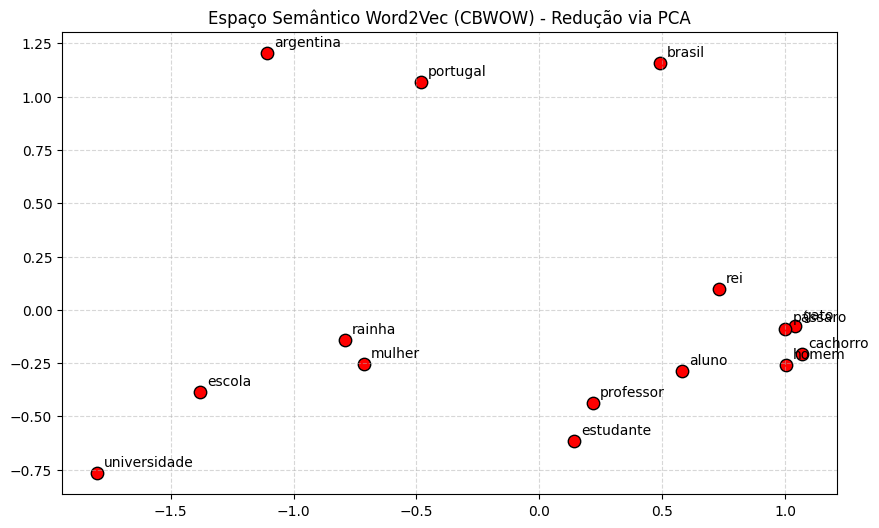

In [63]:
repo_id = "nilc-nlp/word2vec-cbow-50d"

path = hf_hub_download(repo_id=repo_id, filename="embeddings.safetensors")
data = load_file(path)
vectors = data["embeddings"]

vocab_path = hf_hub_download(repo_id=repo_id, filename="vocab.txt")
with open(vocab_path, "r", encoding="utf-8") as f:
    vocab = [w.strip() for w in f]

word2idx = {word: i for i, word in enumerate(vocab)}

palavras_para_plotar = [
    'escola', 'professor', 'aluno', 'estudante', 'universidade',
    'homem', 'mulher', 'rei', 'rainha',
    'cachorro', 'gato', 'pássaro',
    'brasil', 'portugal', 'argentina'
]

comparar_distancias("professor", "professora")
comparar_distancias("professor", "feijão")

plotar_vetores(palavras_para_plotar, 'Word2Vec (CBWOW)','red')

### **GloVe**
Diferentemente do Word2Vec que se concentra na relação local entre as palavras, o modelo Global Vector (GloVe) adota uma perspectiva global, levando em consideração a coocorrência palavra-palavra em um corpus.


--- Comparando 'professor' e 'professora' ---
Distância Euclidiana: 4.1022
Similaridade de Cosseno: 0.7185 (Escala: 0 a 1)

--- Comparando 'professor' e 'feijão' ---
Distância Euclidiana: 7.1747
Similaridade de Cosseno: 0.1078 (Escala: 0 a 1)


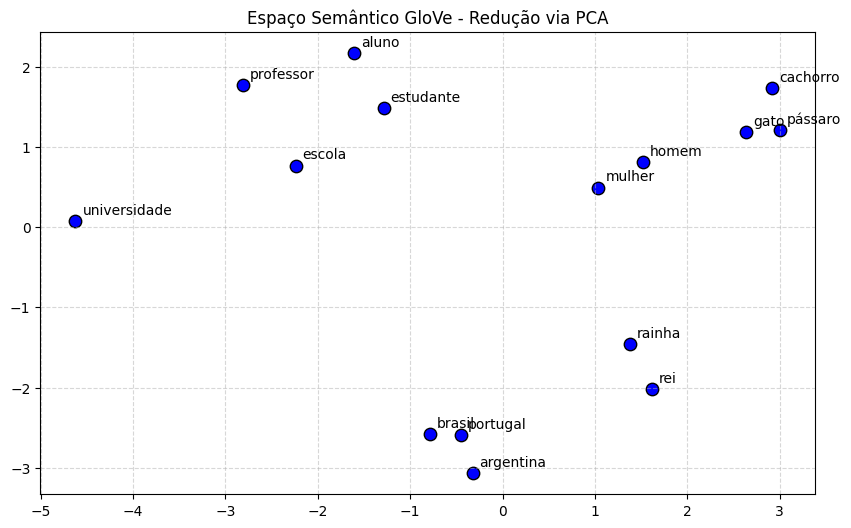

In [64]:
repo_id = "nilc-nlp/glove-50d"

path = hf_hub_download(repo_id=repo_id, filename="embeddings.safetensors")
data = load_file(path)
vectors = data["embeddings"]

vocab_path = hf_hub_download(repo_id=repo_id, filename="vocab.txt")
with open(vocab_path, "r", encoding="utf-8") as f:
    vocab = [w.strip() for w in f]

word2idx = {word: i for i, word in enumerate(vocab)}

palavras_para_plotar = [
    'escola', 'professor', 'aluno', 'estudante', 'universidade',
    'homem', 'mulher', 'rei', 'rainha',
    'cachorro', 'gato', 'pássaro',
    'brasil', 'portugal', 'argentina'
]

comparar_distancias("professor", "professora")
comparar_distancias("professor", "feijão")

plotar_vetores(palavras_para_plotar, 'GloVe', 'blue')

## **Modelos de linguagem**


### **Arquitetura *encoder* - BERT**
Aqui vamos tratar do codificador, ou seja, dada uma entrada em texto, teremos a codificação dela e a saída será o embedding correspondente.


In [65]:
nome_modelo = 'neuralmind/bert-base-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(nome_modelo)
model = AutoModel.from_pretrained(nome_modelo)

frase_1 = "O banco cobrou juros altos."
frase_2 = "Sentei no banco da praça."

def get_bert_embedding(frase):
    inputs = tokenizer(frase, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

emb_1 = get_bert_embedding(frase_1)
emb_2 = get_bert_embedding(frase_2)

sim = cosine_similarity(emb_1, emb_2)[0][0]
print(f"Contextualização com BERT:")
print(f"Similaridade entre as frases com sentidos diferentes de 'banco': {sim:.4f}")

Contextualização com BERT:
Similaridade entre as frases com sentidos diferentes de 'banco': 0.5782


#### **Arquitetura *decoder* - GPT**
O propósito dessa arquitetura é o mesmo que já discutimos antes: gerar o próximo token, dados os tokens anteriores a ele, logo, gerar um texto.

In [66]:
gerador = pipeline('text-generation', model='pierreguillou/gpt2-small-portuguese')

prompt = "A inteligência artificial é importante porque"

print("Gerando texto com GPT (Next Token Prediction):\n")
resultado = gerador(prompt, max_length=50, num_return_sequences=1, truncation=True)

for i, res in enumerate(resultado):
    print(f"Texto Gerado:\n{res['generated_text']}")

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Gerando texto com GPT (Next Token Prediction):

Texto Gerado:
A inteligência artificial é importante porque permite que as pessoas saibam se o interesse está no bem-estar, não no lucro, não no bem-estar de alguma forma. A inteligência artificial é, portanto, um bom método de fazer o que as pessoas pensam.

O estudo da inteligência artificial é muito importante para a sociedade humana porque é a base dos princípios da democracia e da liberdade. A sociedade humana deve ser capaz de explorar a inteligência artificial, para que seja possível conhecer melhor os princípios da democracia e da liberdade.

O projeto de inteligência artificial está sendo desenvolvido desde o início, nos anos 80, com o objetivo de descobrir as leis de como a inteligência artificial funciona e, com isso, verificar se existe uma relação entre a inteligência artificial e a democracia.

O resultado da análise da inteligência artificial está gerando uma nova forma de pensar na democracia e a liberdade.

O Projeto de I

#### **Referências**
* **[Processamento de Linguagem Natural: Conceitos, Técnicas e Aplicações em Português (3ª Ed.)](https://brasileiraspln.com/livro-pln/3a-edicao/)** — Livro texto base do curso.
* **[NLTK Documentation](https://www.nltk.org/)** — Natural Language Toolkit.
* **[Scikit-learn Documentation](https://scikit-learn.org/stable/)** — Biblioteca utilizada para TF-IDF e PCA.
* **[SciPy Documentation](https://docs.scipy.org/doc/scipy/)** — Biblioteca utilizada para cálculos de distância espacial.
* **[Hugging Face Documentation](https://huggingface.co/docs)** — Plataforma para modelos de Transformers e Datasets.
* **[Repositório de Word Embeddings do NILC-USP](https://huggingface.co/nilc-nlp)** — Fonte oficial dos modelos Word2Vec e GloVe treinados em português.

---

#### **Acompanhe a LADATA**  
[![Instagram](https://img.shields.io/badge/Instagram-%40ladata.ufs-E4405F?style=for-the-badge&logo=instagram&logoColor=white)](https://www.instagram.com/ladata.ufs/)  
[![GitHub](https://img.shields.io/badge/GitHub-ladata--ufs-100000?style=for-the-badge&logo=github&logoColor=white)](https://github.com/ladata-ufs)  
[![LinkedIn](https://img.shields.io/badge/LinkedIn-LADATA_UFS-0077B5?style=for-the-badge&logo=linkedin&logoColor=white)](https://br.linkedin.com/company/ladata-ufs)  

<small>
Processamento de Linguagem Natural: das abordagens clássicas aos LLMs | XI SEMAC - 2025 <br>
<strong>Liga Acadêmica de Ciência de Dados | LADATA</strong>
</small>